In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
#from visualization import visualize, display, sequence_identity
from rdkit.Chem import AllChem
from scipy.stats import spearmanr, ttest_ind

import matplotlib as mpl
font = {'size' : 16}
mpl.rc('font', **font)
mpl.rc('lines', linewidth=1.5)
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.width'] = 2

#find the column labeled as ['0']
def find_column(df, label):
    for i, col in enumerate(df.columns):
        if col == label:
            return i
    return None

def get_accuracy_level(predicted_ECs, true_ECs):
    """
    based on a list of predicted_ECs, calculates the highest level of accuracy achieved, against all true_ECs. Returns a list of the same length as true_ECs.
    """
    #convert true_EC to a list
    if type(predicted_ECs) == str:
        predicted_ECs = [predicted_ECs]
        
    if type(true_ECs) == str:
        true_ECs = [true_ECs]

    maxes = []
    for true_EC in true_ECs:

        true_split = true_EC.split('.')
        
        counters = []
        for predicted_EC in predicted_ECs:
            try:
    
                predicted_split = predicted_EC.split('.')
                counter = 0
    
                for predicted, true in zip(predicted_split, true_split):
                    if predicted == true:
                        counter += 1
                    else:
                        break
                counters.append(counter)
                #print(counters)
            except:
                print("ERROR:", predicted_EC)
        
        maxes.append(np.max(counters))
    return maxes
#import umap

#supress warnings
import warnings
warnings.filterwarnings("ignore")

In [27]:
df = pd.read_csv('/disk1/jyang4/repos/CARE/task1_baselines/results_summary/ChatGPT/promiscuous_protein_test_results_df.csv')
df

,Entry,EC number,Sequence,0
0,A0A1E5RUL9,3.1.2.1,NaN,2.7.4.3
1,A0JNI4,5.1.1.18,NaN,2.4.2.9
2,A4YIZ5,4.1.2.13,NaN,2.1.1.177
3,A4YYB6,2.7.7.70,NaN,2.7.1.167
4,A5GT42,2.7.7.23,NaN,4.2.1.10
...,...,...,...,...
174,Q9XWF0,5.3.3.1,NaN,3.5.4.13
175,Q9XZ43,3.6.1.45,NaN,2.7.4.6
176,Q9Z615,1.19.1.1,NaN,2.7.1.71
177,Q9Z6M4,4.2.1.10,NaN,5.3.1.28


In [24]:
df = pd.read_csv('/disk1/jyang4/repos/CARE/task1_baselines/results_summary/CLEAN/promiscuous_protein_test_results_df.csv')
df

,Entry,EC number,Sequence,0,1,2,3,4,5,6,...,4660,4661,4662,4663,4664,4665,4666,4667,4668,4669
0,Q7TS56,1.1.1.100;1.6.5.10,MDKVCAVFGGSRGIGKAVAQLMAQKGYRLAIVARNLEVAKATASEL...,1.6.5.10,1.1.1.100,1.1.1.184,1.1.1.377,1.1.1.398,1.1.1.36,1.1.1.119,...,2.7.1.103,3.2.1.40,1.5.3.6,2.6.1.81,2.1.1.314,5.5.1.20,1.1.3.42,1.14.15.26,2.7.1.187,1.14.14.42
1,Q09851,1.1.1.101;3.1.1.3,MEAEKFVLITGCSEGGIGNALALKFHQEGFQVLATARQVERMDNLT...,1.1.1.105,1.1.1.101,1.1.1.209,1.1.1.62,3.1.1.3,1.1.1.53,1.1.1.144,...,2.1.1.191,6.1.1.19,1.3.1.106,6.1.1.18,2.7.7.61,2.1.1.178,2.5.1.112,2.5.1.72,2.1.1.264,2.2.1.11
2,Q95JH7,1.1.1.112;1.1.1.149;1.1.1.209;1.1.1.210;1.1.1....,MDSKHQCVKLNDGHFMPVLGFGTYAPAEVPKNKALEATKLAIEAGF...,1.1.1.112,1.1.1.149,1.1.1.357,1.1.1.51,1.1.1.210,1.1.1.209,1.1.1.53,...,2.1.1.271,3.5.3.6,2.7.3.3,3.5.3.18,2.5.1.72,4.2.1.85,5.4.2.13,2.2.1.11,2.1.1.130,2.1.1.131
3,P22071,1.1.1.145;1.1.1.210;1.1.1.270;5.3.3.1,MPGWSCLVTGAGGFVGQRIIRMLVQEKELQEVRALDKVFRPETKEE...,1.1.1.145,5.3.3.1,1.1.1.210,1.1.1.270,1.1.3.6,1.1.1.51,1.1.1.357,...,4.1.2.17,4.2.1.85,2.6.1.16,5.4.2.10,2.7.3.1,5.4.2.13,2.2.1.7,2.7.3.3,2.6.1.81,2.2.1.11
4,Q9XWF0,1.1.1.145;5.3.3.1,MSIKRLSMRLKKGIHRSWNRMTSLEAGLEEEKEIKIVEEPEPRPWK...,1.1.1.170,5.3.3.1,1.1.1.145,1.1.1.270,1.3.99.5,3.4.21.45,2.1.1.263,...,2.1.1.191,5.4.2.13,1.3.1.43,2.7.2.3,4.2.1.85,4.1.1.51,2.6.1.81,2.7.1.50,3.5.3.22,2.1.1.264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174,Q1LRV9,4.3.1.23;5.4.3.6,MPHAHPADIDGHHLTPDTVAAIARGQRAAIVPEPVLGKVADARARF...,4.3.1.3,4.3.1.23,5.4.3.6,4.3.1.24,2.7.14.1,2.4.2.52,2.3.3.5,...,1.14.14.11,3.4.24.65,2.4.1.272,2.4.1.26,1.1.5.5,1.14.19.49,3.4.21.26,2.4.1.273,2.4.1.63,3.4.24.22
175,P30904,5.3.2.1;5.3.3.12,MPMFIVNTNVPRASVPEGFLSELTQQLAQATGKPAQYIAVHVVPDQ...,5.3.2.1,5.3.3.12,1.14.18.1,4.1.1.84,3.1.2.22,2.7.3.2,5.2.1.14,...,2.5.1.114,1.1.1.361,2.7.1.187,2.3.1.285,2.3.2.35,1.1.1.384,1.14.14.11,2.3.1.150,3.4.11.23,1.1.1.312
176,P10378,6.2.1.71;6.3.2.14,MSIPFTRWPEEFARRYREKGYWQDLPLTDILTRHAASDSIAVIDGE...,6.2.1.71,6.3.2.14,6.2.1.61,3.3.2.1,6.2.1.65,6.2.1.8,6.2.1.41,...,1.14.11.25,1.14.20.5,1.14.19.33,3.4.24.65,1.14.19.39,3.2.1.130,1.14.14.11,3.4.24.22,2.2.1.11,2.7.1.187
177,Q80WS1,6.3.1.17;6.3.2.41,MCSSVTGKLWFLTDRRIREDYPQKEILRALKAKCCEEELDFRAVVM...,6.3.1.17,6.3.2.41,6.3.2.42,4.1.1.17,6.3.2.25,4.1.1.18,2.1.1.319,...,4.1.1.51,2.7.1.146,1.14.15.26,2.4.1.251,6.2.1.65,6.1.1.17,2.6.1.81,6.2.1.71,6.2.1.61,6.1.1.19


### results must be processed into the correct format as csvs under `results_summary`

In [2]:
task1_baselines = ['Random', 'BLAST', 'ChatGPT', 'ProteInfer', 'CLEAN']
task1_splits = ['30', '30-50', 'price', 'promiscuous']

task2_baselines = ['Random', 'Similarity', 'CLIPZyme', 'CREEP', 'CREEP_text']
task2_splits = ['easy', 'medium', 'hard']

reference_EC_list = np.loadtxt('processed_data/EC_list.txt', dtype=str)
num_ECs = len(reference_EC_list)

In [6]:
#generate and save random EC rankings for each task and all splits
for task in ['task1', 'task2']:
    if task == 'task1':
        baselines = task1_baselines
        splits = task1_splits
        modality = 'protein'
    else:
        baselines = task2_baselines
        splits = task2_splits
        modality = 'reaction'

    for split in splits:
        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baselines[1], split, modality))

        num_cols = find_column(query_df, '0')
        print(num_cols)

        for i in range(query_df.shape[0]):
            np.random.seed(42)
            #shuffle the columns
            query_df.iloc[i, num_cols:] = query_df.iloc[i, num_cols:].sample(frac=1).values
        
        query_df.to_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, 'Random', split, modality), index=False)

3
3
3
3
9
9
9


In [22]:
results = pd.DataFrame(columns=['baseline', 'split', 'k', 'level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy'])

#load the query_df that's already been generated
task  = 'task2'

if task == 'task1':
    baselines = task1_baselines
    splits = task1_splits
    modality = 'protein'
else:
    baselines = task2_baselines
    splits = task2_splits
    modality = 'reaction'

for baseline in baselines:
    for split in splits:

        query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality)) #take a different baseline and randomize it
        # if task == 'task1':
        #         num_cols = 3
        # else:
        #     num_cols = len(query_df.columns) - num_ECs
        num_cols = find_column(query_df, '0')

        # query_df = pd.read_csv('{}_baselines/results_summary/{}/{}_{}_test_results_df.csv'.format(task, baseline, split, modality))
        # num_cols = sum(isinstance(name, str) for name in query_df.columns)
        # print(num_cols)
        #query_df = query_df.iloc[141:142,:]


        #make a k=1 retrieval accuracy table, broken down by accuracy greater than or equal to level 1, 2, 3, 4

        # for k in [1, 5, 10]:

        #change this line if you have fewer rankings available
        for k in [1, 3, 5, 10, 20, 30, 40, 50]:
            #collapse columns 0:3 into a single column list
            query_df['predicted ECs'] = query_df.iloc[:, num_cols:num_cols+k].values.tolist()
            query_df['EC number list'] = query_df['EC number'].apply(lambda x: x.split(';'))
            
            query_df['k={} accuracy level'.format(k)] = query_df.apply(lambda x: get_accuracy_level(x['predicted ECs'],  x['EC number list']), axis=1)

            accuracies = []
            for i in [4, 3, 2, 1]:
                exploded = query_df.explode('k={} accuracy level'.format(k))
                accuracy = exploded[exploded['k={} accuracy level'.format(k)] >= i].shape[0] / exploded.shape[0]
                accuracies.append(round(accuracy*100, 1))
                
            results.loc[len(results)] = [baseline, split, k, accuracies[0], accuracies[1], accuracies[2], accuracies[3]]

In [16]:
results[results['k'] == 1].sort_values(by='split')[results['split'] != 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,30,1,11.4,13.7,14.9,27.4
12,ChatGPT,30,1,11.4,13.7,14.9,27.4
24,ProteInfer,30,1,61.8,66.5,69.4,73.4
36,CLEAN,30,1,57.7,68.6,73.7,80.6
3,Random,30-50,1,9.7,10.7,12.2,21.4
15,ChatGPT,30-50,1,9.7,10.7,12.2,21.4
27,ProteInfer,30-50,1,78.5,84.1,86.7,89.7
39,CLEAN,30-50,1,82.1,91.8,95.4,99.0
6,Random,price,1,0.7,5.4,8.1,18.8
18,ChatGPT,price,1,0.7,5.4,8.1,18.8


In [23]:
results[results['k'] == 5][results['split'] == 'promiscuous']

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
10,Random,promiscuous,5,6.1,8.9,20.1,31.3
22,BLAST,promiscuous,5,93.9,94.4,95.0,97.8
34,ChatGPT,promiscuous,5,6.1,8.9,20.1,31.3
46,ProteInfer,promiscuous,5,76.0,81.0,84.9,90.5
58,CLEAN,promiscuous,5,96.3,98.0,98.3,99.5


In [7]:
results

,baseline,split,k,level 4 accuracy,level 3 accuracy,level 2 accuracy,level 1 accuracy
0,Random,easy,1,0.0,0.0,0.6,13.6
1,Random,easy,3,0.0,0.6,3.4,35.6
2,Random,easy,5,0.0,0.6,6.2,50.8
3,Random,easy,10,0.0,4.5,18.1,82.5
4,Random,easy,20,0.0,11.3,42.4,92.7
...,...,...,...,...,...,...,...
85,CREEP_text,hard,3,4.3,25.8,44.2,77.9
86,CREEP_text,hard,5,8.0,31.9,52.8,84.7
87,CREEP_text,hard,10,16.6,42.9,65.0,95.1
88,CREEP_text,hard,20,22.1,61.3,75.5,99.4


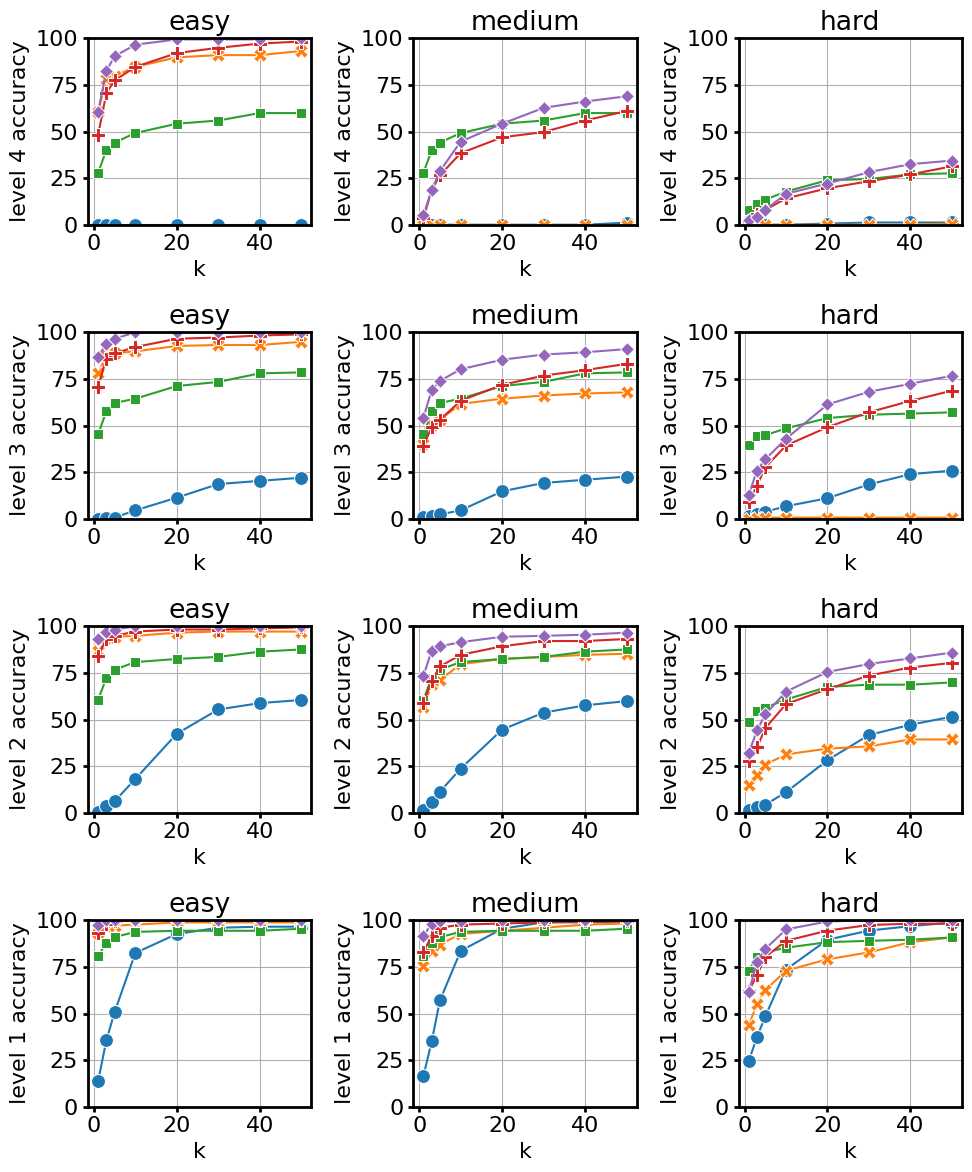

In [27]:
plt.figure(figsize=(10, 12))
i = 0
for metric in ['level 4 accuracy', 'level 3 accuracy', 'level 2 accuracy', 'level 1 accuracy']:
    for split in splits:
        i += 1
        plt.subplot(4, 3, i)
        subset = results[results['split'] == split]
        sns.lineplot(data=subset, x="k", y=metric, hue="baseline", markers=True, style="baseline", dashes=False, markersize=10, legend=False)
        plt.title(split)
        plt.grid(True)
        plt.ylim(0, 100)
plt.tight_layout()

### Measure similarity to reactions in the train set

In [16]:
results = pd.DataFrame()
for split in ['easy', 'medium', 'hard']:
    reaction_similarities = np.load('/disk1/jyang4/repos/CARE/task2_baselines/Similarity/output/{}_split/retrieval_results/{}_reaction_test_reaction2reaction_retrieval_similarities.npy'.format(split, split))
    query_df = pd.read_csv('task2_baselines/results_summary/CREEP/{}_reaction_test_results_df.csv'.format(split))
    reference_df = pd.read_csv('splits/task2/{}_reaction_train.csv'.format(split))

    query_df['Correct'] = query_df['EC number'] == query_df['0']
    #apply get accuracy level
    query_df['k=1 accuracy level'] = query_df.apply(lambda x: get_accuracy_level(x['0'], x['EC number'])[0], axis=1)
    query_df['Similarity'] = np.max(reaction_similarities, axis=1)
    query_df = query_df.sort_values(by='Similarity', ascending=False)
    query_df['Split'] = split
    results = pd.concat([results, query_df], axis=0)
results

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4667,4668,4669,4670,4671,4672,Correct,k=1 accuracy level,Similarity,Split
79,CC(O)[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@H](Cc1cc...,[CH3:1][CH:2]([OH:3])[C@H:4]([NH:5][C:6](=[O:7...,2.7.14.1,ATP + a [protein]-L-arginine = ADP + a [protei...,2.7.14,2.70,2,True,1,2.7.11.19,...,3.1.1.105,2.1.1.278,4.2.1.105,2.1.1.50,4.2.99.23,4.2.99.22,False,2,1.0,easy
159,C/C(=C\C(=O)O)C(=O)SCCNC(=O)CCNC(=O)[C@H](O)C(...,[CH3:1]/[C:2](=[CH:3]\[C:4](=[O:5])[OH:6])[C:7...,5.4.1.3,2-methylfumaryl-CoA = 3-methylfumaryl-CoA {r},5.4.1,5.40,5,True,1,5.4.1.3,...,3.2.1.123,3.5.1.101,2.4.1.68,3.5.1.105,3.2.1.99,3.5.1.125,True,4,1.0,easy
35,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[H+].[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C...,1.21.4.1,D-proline + NADH = 5-aminopentanoic acid + NAD+,1.21.4,1.21,1,True,1,1.21.4.1,...,5.3.99.11,4.1.3.32,4.99.1.8,6.5.1.4,6.5.1.5,2.4.1.290,True,4,1.0,easy
82,Nc1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O)[C@@...,[NH2:1][c:2]1[cH:3][cH:4][n:5]([C@@H:6]2[O:7][...,2.7.4.10,CTP + AMP = CDP + ADP {r},2.7.4,2.70,2,True,1,2.7.4.8,...,3.1.1.87,3.1.1.72,3.1.1.1,3.1.1.73,4.2.99.23,4.2.99.22,False,3,1.0,easy
41,C=CC1=C(C)C(CC2=N/C(=C3\c4[nH]c(Cc5[nH]c(C=O)c...,[CH2:1]=[CH:2][C:3]1=[C:4]([CH3:5])[CH:6]([CH2...,1.3.7.12,primary fluorescent chlorophyll catabolite + N...,1.3.7,1.30,1,True,1,1.3.7.12,...,3.1.3.22,1.14.11.46,3.1.3.63,1.14.11.71,3.1.3.3,3.1.3.50,True,4,1.0,easy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,3,0.0,hard


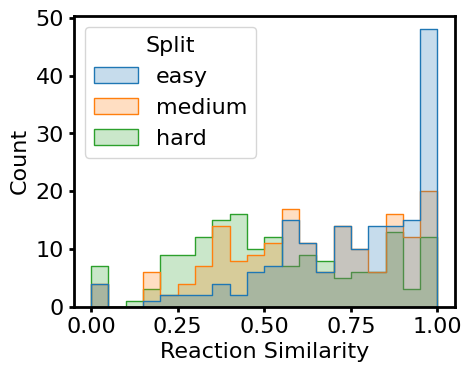

In [7]:
plt.figure(figsize=(5, 4))
sns.histplot(results, x='Similarity', hue='Split', element="step",stat="count", bins=20, fill=True)
sns.move_legend(plt.gca(), "upper left")
plt.xlabel('Reaction Similarity')
plt.tight_layout()
plt.savefig('generate_datasets_splits/figs/task2_similarity_histogram.png', dpi=500)

### Visualize if predictions on the more similar reactions are more accurate

Ttest_indResult(statistic=5.104055220328118, pvalue=4.6850408074296735e-07)


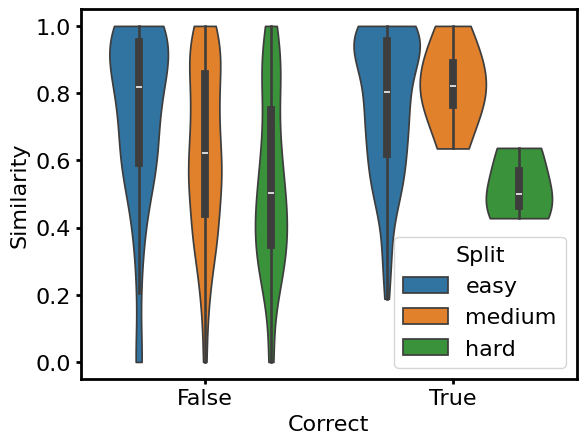

In [17]:
#calculate the correlation between correct and reaction similarity
#print(spearmanr(merged['reaction_similarity'],merged['correct']))
#subset = results[results['Split'] == 'hard']
print(ttest_ind(results[results['Correct']]['Similarity'], results[~results['Correct']]['Similarity']))
sns.violinplot(data=results, x='Correct', y='Similarity', hue='Split', cut=False)

SpearmanrResult(correlation=0.2997393476798378, pvalue=3.4144401043179985e-12)


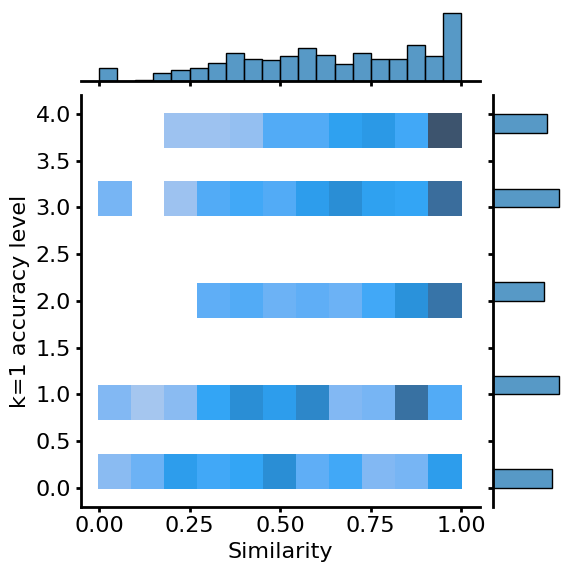

In [25]:
print(spearmanr(results['Similarity'], results['k=1 accuracy level']))
sns.jointplot(data=results, x='Similarity', y='k=1 accuracy level', kind='hist', marginal_kws=dict(bins=20, fill=True))


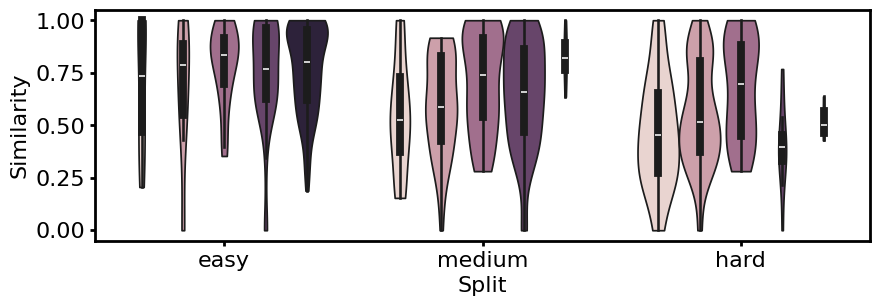

In [37]:
plt.figure(figsize=(10, 3))
sns.violinplot(data=results, x='Split', y='Similarity', hue='k=1 accuracy level', cut=False, legend=False, density_norm="count")

### Visualize some of the reactions with highest and lowest similarity

The most recent query_df should be for the hard set

In [43]:
query_df

,Reaction,Mapped Reaction,EC number,Reaction Text,EC3,EC2,EC1,Duplicated EC,Reactions with a single EC,0,...,4666,4667,4668,4669,4670,4671,4672,Correct,Similarity,Split
77,N[C@@H](CCS)C(=O)O.O=c1[nH]cnc2c1ncn2[C@@H]1O[...,[NH2:1][C@@H:2]([CH2:3][CH2:4][SH:5])[C:6](=[O...,3.13.1.9,S-inosyl-L-homocysteine + H2O = inosine + L-ho...,3.13.1,3.13,3,True,1,3.5.4.28,...,1.6.3.2,1.8.1.18,2.7.8.23,5.4.99.2,5.4.2.9,3.7.1.1,3.11.1.3,False,1.0,hard
94,Nc1ncnc2c1ncn2[C@H]1CC[C@@H](COP(=O)(O)OP(=O)(...,[NH2:1][c:2]1[n:3][cH:4][n:5][c:6]2[c:7]1[n:8]...,3.6.4.13,"2',3'-dideoxy-ATP + H2O = 2',3'-dideoxy-ADP + ...",3.6.4,3.60,3,True,1,3.6.1.6,...,2.3.1.248,2.3.1.133,2.3.1.184,2.3.2.30,2.3.1.302,2.3.1.144,2.3.1.28,False,1.0,hard
146,CNc1ccccc1C(=O)O[C@H]1[C@@H](O)[C@H](n2cnc3c(N...,[CH3:1][NH:2][c:3]1[cH:4][cH:5][cH:6][cH:7][c:...,5.6.2.4,2'(3')-O-(N-methylanthraniloyl)ATP + H2O = 2'(...,5.6.2,5.60,5,True,1,3.6.5.3,...,4.1.1.19,2.3.1.109,1.8.1.19,4.1.1.17,2.1.4.1,2.1.4.3,2.1.4.2,False,1.0,hard
31,NC(=O)C1=CN([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)O...,[NH2:1][C:2](=[O:3])[C:4]1=[CH:5][N:6]([C@@H:7...,1.6.1.1,NADH + 3'-NADP+ = NAD+ + 3'-NADPH,1.6.1,1.60,1,True,1,2.7.1.23,...,2.1.1.141,1.13.12.5,3.7.1.8,3.7.1.14,3.8.1.5,3.7.1.25,3.7.1.9,False,1.0,hard
65,CC(C)C[C@H](NC(=O)[C@H](CCCCN)NC(=O)[C@@H](N)C...,[CH3:1][CH:2]([CH3:3])[CH2:4][C@H:5]([NH:6][C:...,2.7.11.13,ATP + FKLKRKGSFKKFA = ADP + FKLKRKGpSFKKFA,2.7.11,2.70,2,True,1,2.7.12.1,...,3.1.1.6,3.1.1.56,3.1.1.104,3.1.1.72,3.1.1.25,4.2.1.53,3.1.8.1,False,1.0,hard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,CC(C)(COP(=O)(O)OP(=O)(O)OC[C@H]1O[C@@H](n2cnc...,[CH3:1][C:2]([CH3:3])([CH2:4][O:5][P:6](=[O:7]...,1.2.7.4,propionyl-SCoA + CoASH = propionyl-SCoA + CoAS...,1.2.7,1.20,1,True,1,2.3.1.155,...,1.17.9.1,3.2.1.24,3.2.1.11,1.1.3.5,3.2.1.57,5.5.1.20,1.1.3.42,False,0.0,hard
128,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.99.1.9,protoporphyrin IX + Cu2+ = Cu-protoporphyrin I...,4.99.1,4.99,4,True,1,1.5.99.15,...,2.7.1.6,2.4.1.13,1.14.15.35,6.3.1.1,2.3.1.109,2.3.2.30,2.4.1.245,False,0.0,hard
127,C=Cc1c(C)c2cc3[nH]c(cc4nc(cc5nc(cc1[nH]2)C(C)=...,[CH2:1]=[CH:2][c:3]1[c:4]([CH3:5])[c:6]2[cH:7]...,4.98.1.1,Cd2+-protoporphyrin + H+ = protoporphyrin + Cd2+,4.98.1,4.98,4,True,1,3.5.4.27,...,2.4.1.245,2.3.1.183,2.3.1.271,2.3.1.53,2.7.1.157,2.3.1.109,2.3.2.30,False,0.0,hard
78,O.O=C(O)[C@H]1O[C@H](O[C@@H]2[C@H](O)[C@@H](O)...,[O:2]=[C:3]([OH:4])[C@H:5]1[O:6][C@H:7]([O:8][...,3.2.1.15,"alpha-D-galacturonosyl-(1,4)-O-alpha-D-galactu...",3.2.1,3.20,3,True,1,3.2.1.40,...,2.7.4.26,2.7.14.1,2.7.4.16,2.7.1.39,2.1.1.5,2.7.3.3,2.1.1.258,False,0.0,hard


In [65]:
rxns = []
rxn2s = []
for index in query_df.index:
    rxn = query_df['Reaction'].values[index]
    EC_number = query_df['EC number'].values[index]
    predicted_EC_number = query_df['0'].values[index]

    reference_subset = reference_df[reference_df['EC number'] == predicted_EC_number]
    if len(reference_subset) == 1:
        rxn2 = reference_subset['Reaction'].values[0]
        
        rxns.append(rxn)
        rxn2s.append(rxn2)

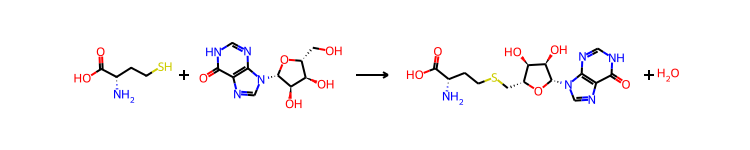

In [77]:
index=0
AllChem.ReactionFromSmarts(rxns[index], useSmiles=True)

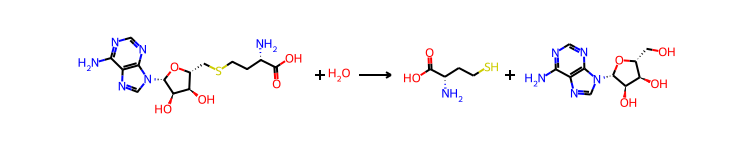

In [78]:
AllChem.ReactionFromSmarts(rxn2s[index], useSmiles=True) 